# Simulation of Kuramoto Model with Watts-Strogratz Small world Network


In [40]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import odeint
import seaborn as sns

# Instructions

## Kuramoto Oscillator
- The number of oscillators chosen are 100
- The simulation time is 10 seconds with a time step of 0.1
- Distribution of omega is standard normal distribution
## Small World Network
- The Number of Nodes is equivalent to number of oscillators
- Both the Regular and Randomized Networks is used and results the used to compare between the two
- The probability (p) for Regular is 0.95 whereas for Randomized portion is 0.05
## Results
Following plots are used for visualizing the dynamics of the Network system:-
- The Circular and Default layout network of both Regular and Randomized Watts-Strogatz network model
- The omega frequency distribution between two networks
- The order parameter(r) v/s Coupling strength(K) plot in both cases of Regular and Randomized Network
- The order parameter(r) v/s Time (t) plot in both cases of Regular and Randomized Network
- The degree distribution plots i.e. Bar graph between Fraction of nodes v/s Degree of nodes for both Regular and Random Network
- The Clustering Coefficient Distribution histogram along with value of Average Clustering Coefficient for both Regular and Random Networks.

# Class program of Kuramoto-Watts_strogatz Network Model

In [ ]:
class Network_kuramoto:
    def __init__(self, K_values_time, K_values, N, time, dt, k, p):
        """Setting up the Parameters for the Kuramoto Model"""
        self.K_values_time = K_values_time  # Coupling strengths for r vs. time
        self.K_values = K_values            # Coupling strengths for r vs. K (Kc curve)
        self.N = N                          # Number of oscillators
        self.time = time                    # Total simulation time
        self.dt = dt                        # Time step
        self.t_span = np.arange(0, time, dt)
        self.k = k                          # Number of nearest neighbors in Watts–Strogatz
        self.p = p                          # Rewiring probability in Watts–Strogatz

        # Generate the Watts–Strogatz network
        np.random.seed(35)
        self.G_ws = nx.watts_strogatz_graph(N, k, p)
        self.A_ws = nx.to_numpy_array(self.G_ws)
        self.omega = np.random.normal(0, 1, N)  # Natural frequencies
        self.theta0 = 2 * np.pi * np.random.rand(N)  # Initial phase angles

    def kuramoto_equation(self, theta, t, omega, K):
        """Calculating dtheta/dt for each oscillator."""
        dtheta_dt = np.zeros(self.N)
        for i in range(self.N):
            interaction_sum = sum(self.A_ws[i, j] * np.sin(theta[j] - theta[i]) for j in range(self.N))
            dtheta_dt[i] = omega[i] + (K / self.N) * interaction_sum
        return dtheta_dt

    def compute_order_parameter(self, theta):
        """Calculating the order parameter r."""
        total_sum = sum([(np.exp(1j * i)) for i in theta])
        return abs(total_sum / self.N)

    def solve_r_vs_time(self):
        """r over time for each K in K_values_time."""
        r_values_time = {K: [] for K in self.K_values_time}
        for K in self.K_values_time:
            theta_t = odeint(self.kuramoto_equation, self.theta0, self.t_span, args=(self.omega, K))
            r_values_time[K] = [self.compute_order_parameter(theta) for theta in theta_t]
        return r_values_time

    def plot_r_vs_time(self,ax):
        """r vs. time for different K values."""
        r_values_time = self.solve_r_vs_time()
        for K, r_values in r_values_time.items():
            ax.plot(self.t_span, r_values, label=f'K = {K}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Order Parameter (r)')
        ax.legend(loc="upper left")
        ax.set_title('Order Parameter r vs. Time for Different K Values')
        ax.grid()

    def solve_r_vs_K(self):
        """Calculate average r over time for each K in K_values."""
        r_values_K = []
        for K in self.K_values:
            theta_t = odeint(self.kuramoto_equation, self.theta0, self.t_span, args=(self.omega, K))
            r_t = [self.compute_order_parameter(theta) for theta in theta_t]
            r_values_K.append(np.mean(r_t))  # Average r over time
        return r_values_K

    def plot_r_vs_K(self,ax):
        """Plot r vs. K (Kc curve)."""
        r_values_K = self.solve_r_vs_K()
        ax.plot(self.K_values, r_values_K, marker='o')
        ax.set_xlabel('Coupling Strength (K)')
        ax.set_ylabel('Order Parameter (r)')
        ax.set_title('Order Parameter r vs. Coupling Strength K (Kc Curve)')
        ax.grid()

    def plot_omega_distribution(self,ax):
        """Plot the distribution of natural frequencies omega."""
        ax.hist(self.omega, bins=20, density=True, alpha=0.7, color='blue')
        sns.kdeplot(self.omega, color='red', label='KDE', linewidth=2,ax=ax)
        ax.set_xlabel('Natural Frequency (omega)')
        ax.set_ylabel('Density')
        ax.legend(loc="upper right")
        ax.grid(True)

    def plot_network(self):
     """Plot the Watts–Strogatz network."""
    # Create subplots
     fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 

     pos = nx.circular_layout(self.G_ws)  # Circular layout for clarity
     nx.draw(self.G_ws, pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=50, ax=ax[0])
     ax[0].set_title("Watts-Strogatz Circular Network")

     nx.draw(self.G_ws, with_labels=False, node_size=50, node_color="skyblue", edge_color="gray", ax=ax[1])
     ax[1].set_title("Watts-Strogatz Default Layout Network")

     plt.tight_layout()
     if self.p == 0.05:
      plt.suptitle('Randomized_Network',y=0.05)
     else:
        plt.suptitle('Regularized_Network',y=0.05)  
     plt.show()


    def degree_distribution(self,ax):
     degree_sequence = [degree for _, degree in self.G_ws.degree()]
     degree_count = Counter(degree_sequence)
     degrees = list(degree_count.keys())
     fractions = [count / self.N for count in degree_count.values()]

     ax.bar(degrees, fractions, color="blue", width=0.6, label="Fraction of Nodes")
     ax.set_xlabel('Degree')
     ax.set_ylabel('Fraction of Nodes')
     ax.set_title('Degree v/s Fraction_node')
     ax.legend()

    def clustering_distribution(self,ax):
     clustering_coefficients = nx.clustering(self.G_ws)
     clustering_values = list(clustering_coefficients.values())

     avg_clustering = nx.average_clustering(self.G_ws)
     if self.p == 0.05:
        type_network = 'Randomized'
     else:
        type_network = 'Regularized'

     print(f"Average Clustering Coefficient of ({type_network}) is: {avg_clustering:.4f}")

     ax.hist(clustering_values, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
     ax.set_xlabel("Clustering Coefficient")
     ax.set_ylabel("Number of Nodes")
     ax.set_title("Clustering Coefficient Distribution")
     ax.grid(alpha=0.5)


# Initialization of Random and Regular Small-world Network

In [51]:
# Parameters
K_values_time = [0.0, 0.5, 1.0, 1.5, 2.5, 4, 5]  # For r vs. time plot
K_values = np.linspace(0, 8, 40)  # For r vs. K plot
N = 100  # Number of oscillators
T = 10  # Total time to simulate
dt = 0.1  # Time step
k = 5  # Nearest neighbors in Watts–Strogatz
p = 0.05  # Rewiring probability in Watts–Strogatz

# Model initiation
randomised_network = Network_kuramoto(K_values_time, K_values, N, T, dt, k, p)

In [52]:
# Parameters
K_values_time = [0.0, 0.5, 1.0, 1.5, 2.5, 4, 5]  # For r vs. time plot
K_values = np.linspace(0, 8, 40)  # For r vs. K plot
N = 100  # Number of oscillators
T = 10  # Total time to simulate
dt = 0.1  # Time step
k = 5  # Nearest neighbors in Watts–Strogatz
p = 0.95  # Rewiring probability in Watts–Strogatz

# Model initiation
regularized_network = Network_kuramoto(K_values_time, K_values, N, T, dt, k, p)

## The Network plots of Regular and Randomized Network

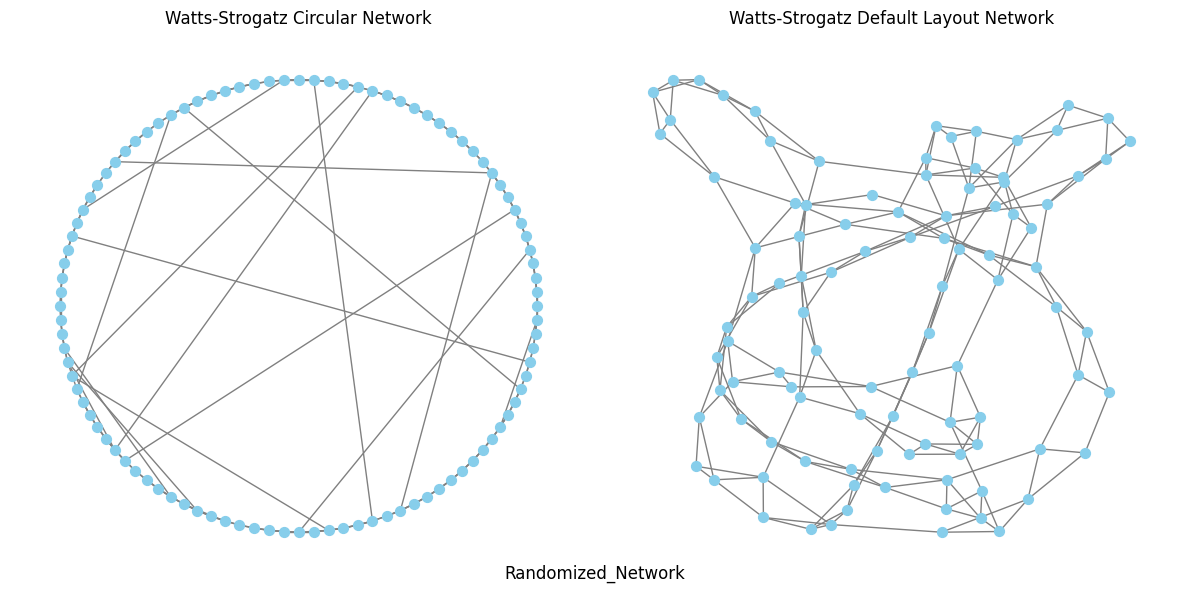

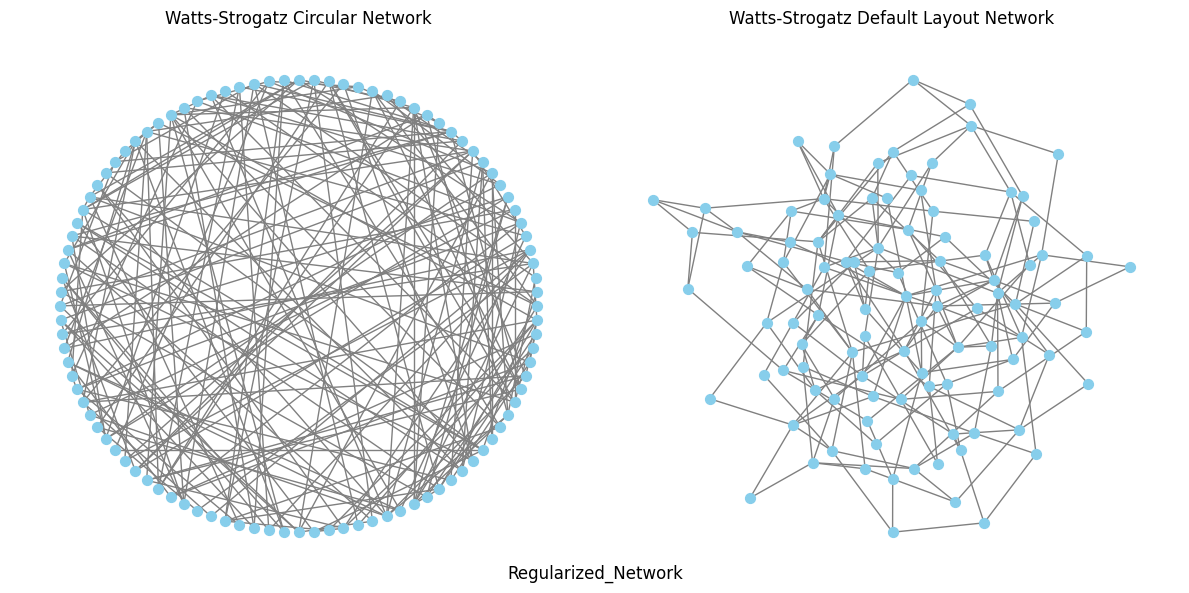

In [44]:
# Network Plot

randomised_network.plot_network()

regularized_network.plot_network()


## Omega Frequency Distribution

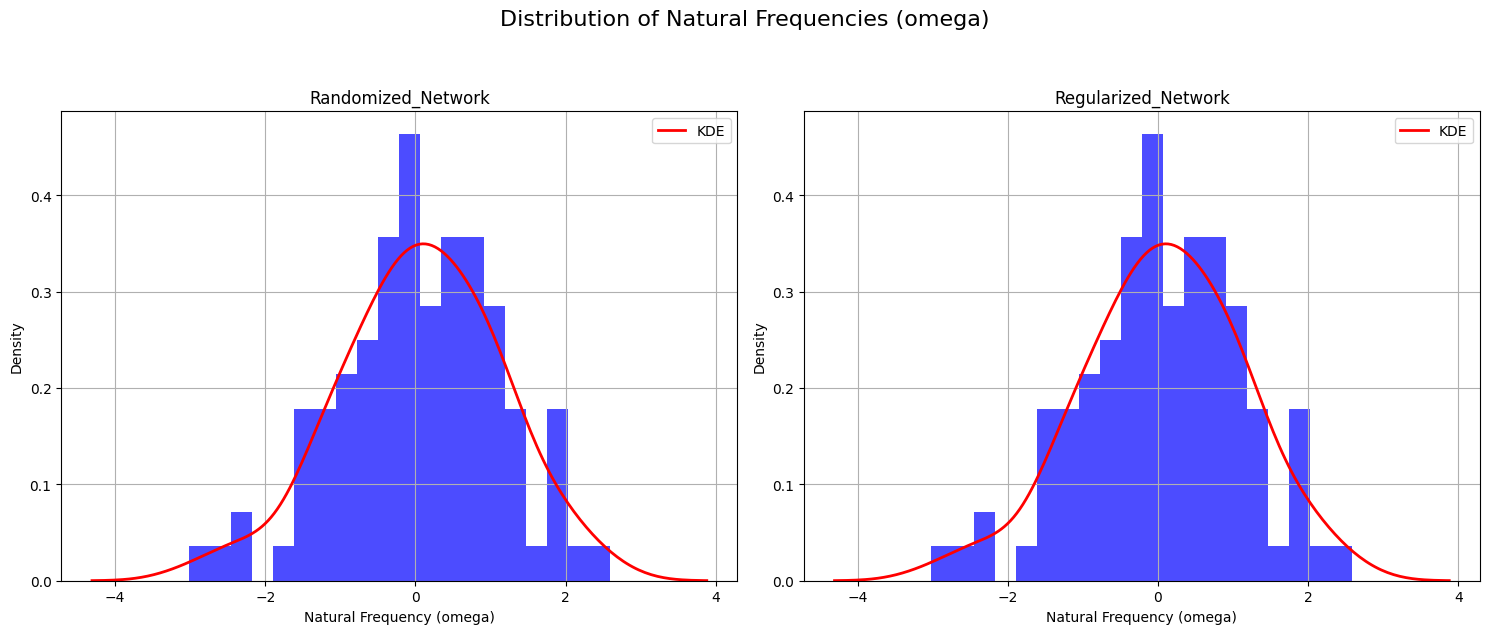

In [45]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

randomised_network.plot_omega_distribution(ax=ax[0])
ax[0].set_title('Randomized_Network')

regularized_network.plot_omega_distribution(ax=ax[1])
ax[1].set_title('Regularized_Network')

fig.suptitle('Distribution of Natural Frequencies (omega)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## Order parameter(r) v/s Coupling strength(K)

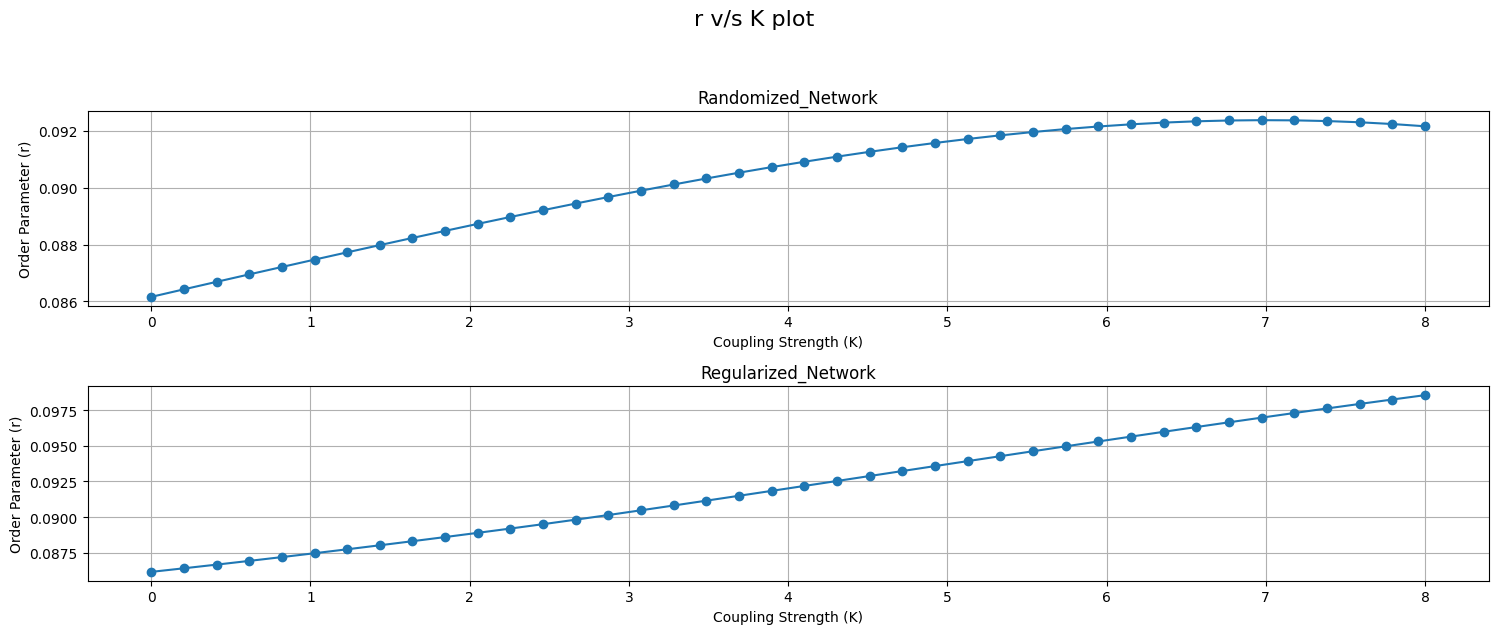

In [46]:
fig,ax = plt.subplots(2,1, figsize=(15,6))

randomised_network.plot_r_vs_K(ax=ax[0])
ax[0].set_title('Randomized_Network')

regularized_network.plot_r_vs_K(ax=ax[1])
ax[1].set_title('Regularized_Network')

fig.suptitle('r v/s K plot', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

## Order parameter(r) v/s Time(t)

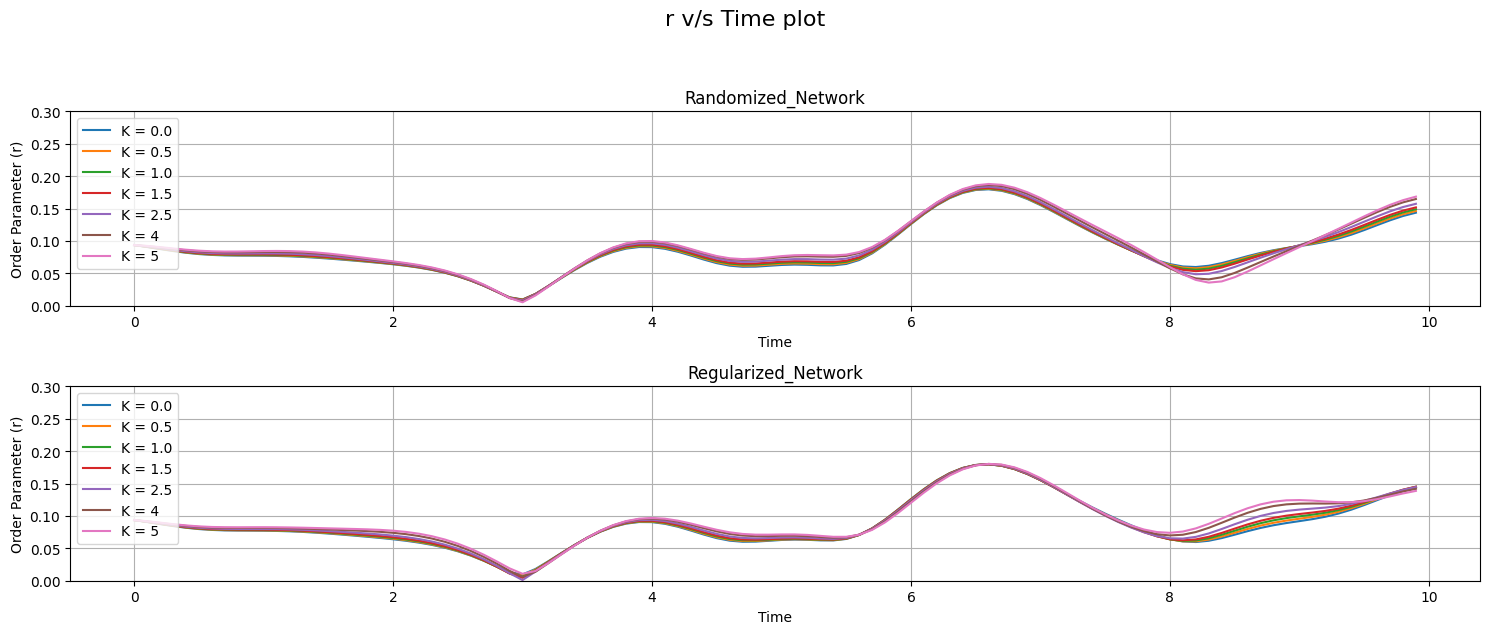

In [47]:
fig,ax = plt.subplots(2,1, figsize=(15,6))

randomised_network.plot_r_vs_time(ax=ax[0])
ax[0].set_title('Randomized_Network')
ax[0].set_ylim(0,0.3)

regularized_network.plot_r_vs_time(ax=ax[1])
ax[1].set_title('Regularized_Network')
ax[1].set_ylim(0,0.3)

fig.suptitle('r v/s Time plot', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

## Nodal Degree Distribution

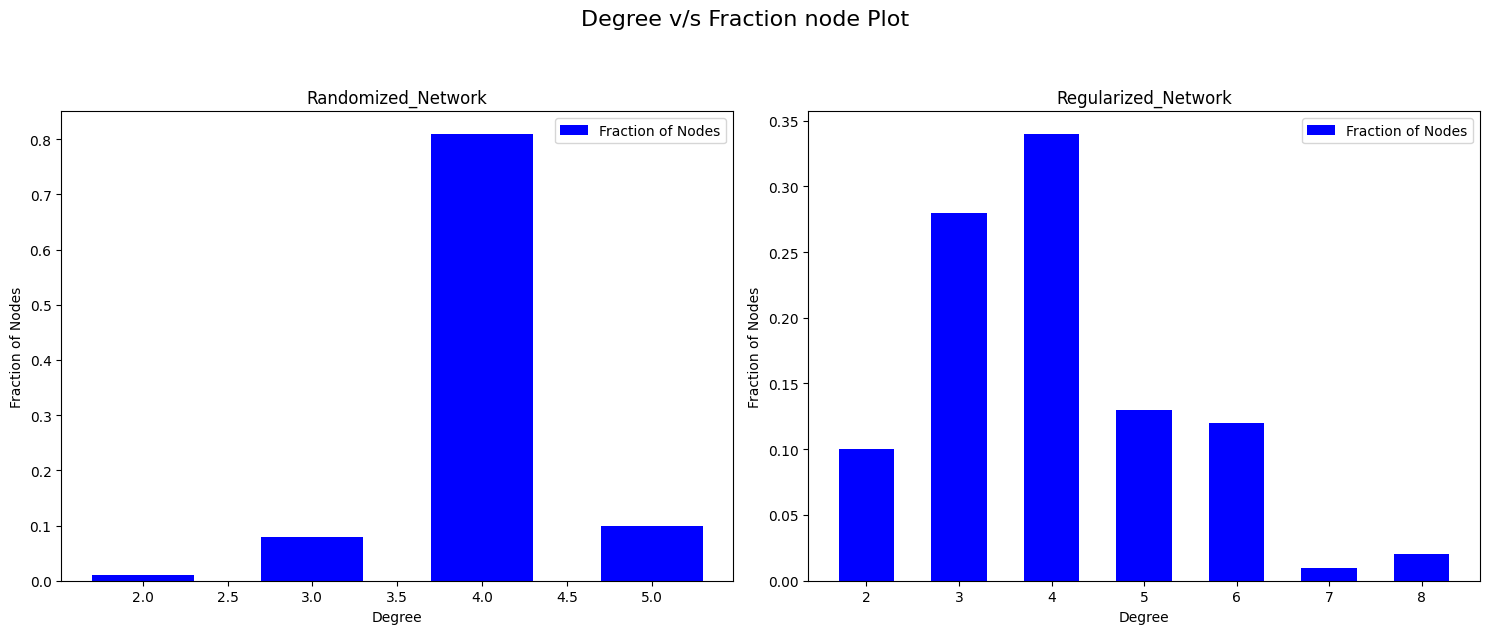

In [53]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

randomised_network.degree_distribution(ax=ax[0])
ax[0].set_title('Randomized_Network')

regularized_network.degree_distribution(ax=ax[1])
ax[1].set_title('Regularized_Network')

fig.suptitle('Degree v/s Fraction node Plot', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Nodal Clustering Distribution

Average Clustering Coefficient of (Randomized) is: 0.4447
Average Clustering Coefficient of (Regularized) is: 0.0337


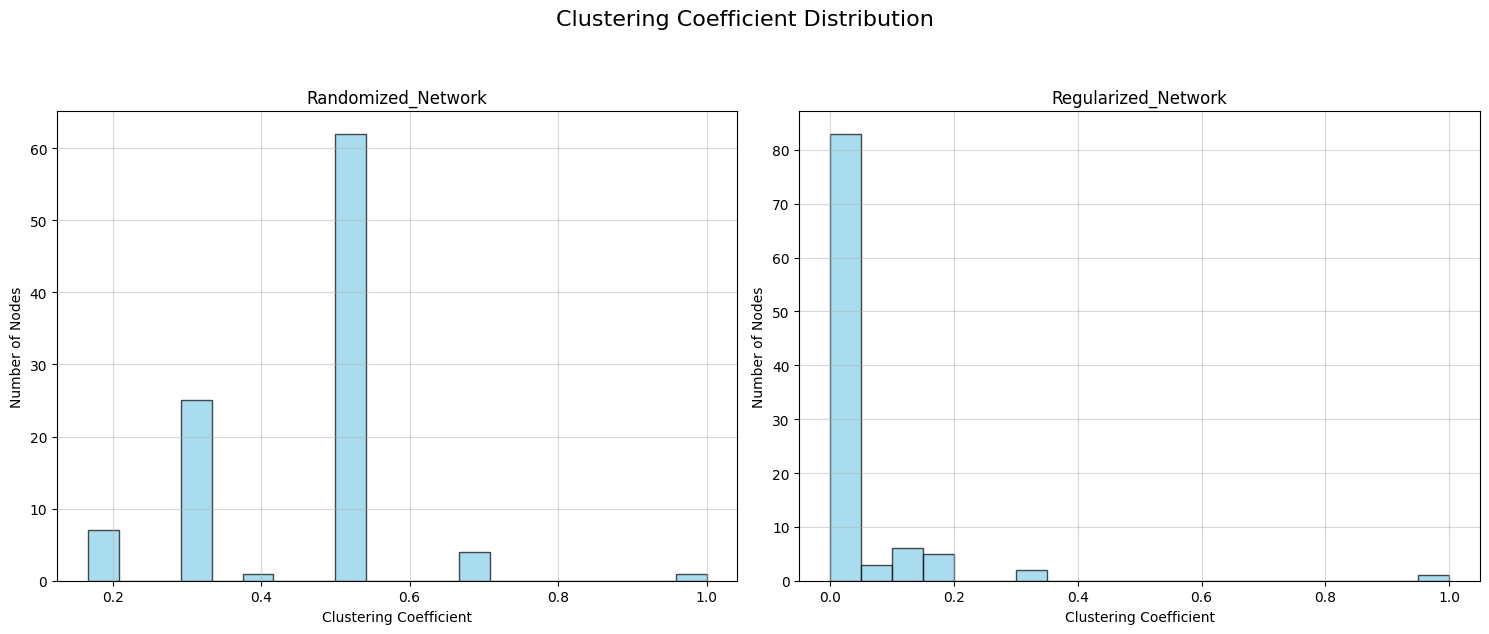

In [54]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

randomised_network.clustering_distribution(ax=ax[0])
ax[0].set_title('Randomized_Network')

regularized_network.clustering_distribution(ax=ax[1])
ax[1].set_title('Regularized_Network')

fig.suptitle('Clustering Coefficient Distribution', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()